In [ ]:
import numpy as np
import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Input
from tensorflow.keras.optimizers import Adam
import os
import zipfile

In [ ]:
#General
import pandas as pd
import numpy as np
import scipy
import scipy.io
import os
import zipfile
import matplotlib.pyplot as plt
from scipy import signal
import librosa
import cv2
from google.colab.patches import cv2_imshow
from PIL import ImageEnhance, Image
import gc

#Deep Learning

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dense, MaxPooling2D, Flatten, Dense, Dropout, concatenate, GlobalAveragePooling2D, AveragePooling2D, Conv1D, MaxPooling1D
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.applications.densenet import DenseNet201, DenseNet121
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import files


In [ ]:
def ReadEEGData(Participant, data_type):

  fs = 200      #Samping Frequency for EEG data

  """ Code below is used to extract relevant details form the .mat file"""

  EEG_data_path = '/tmp/EEG/' + Participant + '-EEG/cnt_' + data_type + '.mat'
  EEG_mrk_path = '/tmp/EEG/' + Participant + '-EEG/mrk_' + data_type + '.mat'
  EEG_Data = scipy.io.loadmat(EEG_data_path)
  EEG_mrk_Data = scipy.io.loadmat(EEG_mrk_path)
  data_struct = EEG_Data['cnt_' + data_type]
  data_array = np.concatenate(data_struct['x'][0])
  markers_struct = EEG_mrk_Data['mrk_' + data_type]

  markers_time = np.round(np.vstack(markers_struct['time'][0]) / 1000 * 200)


  frames_gen = np.vstack(markers_struct['time'][0])
  frames_gen = (frames_gen[0] - frames_gen[0][0]) / 1000

  #For extracting the information of events (corresponding labels)
  markers_events = np.vstack(markers_struct['y'][0])
  markers_events_ints = np.argmax(markers_events, axis = 0)

  """ Next few lines of the code are used for creating data arrays"""

  Data = []
  Labels = []

  for i in range(np.shape(markers_time)[1] - 1):
    temp = data_array[int(markers_time[0][i]):int(markers_time[0][i+1]), :]
    Data.append(temp)

    if data_type == 'nback':
      if markers_events_ints[i] in np.array([0, 5]):
        Labels.append(0)
      elif markers_events_ints[i] in np.array([1, 2, 6]):
        Labels.append(2)
      else:
        Labels.append(3)

    else:
      Labels.append(markers_events_ints[i])

  return Data, Labels, frames_gen

In [ ]:
def ReadNIRSData(Participant, data_type, frames_gen):

  fs = 10      #Samping Frequency for NIRS data

  """ Code below is used to extract relevant details form the .mat file"""

  NIRS_data_path = '/tmp/NIRS/' + Participant + '-NIRS/cnt_' + data_type + '.mat'
  NIRS_mrk_path = '/tmp/NIRS/' + Participant + '-NIRS/mrk_' + data_type + '.mat'

  NIRS_data = scipy.io.loadmat(NIRS_data_path)
  NIRS_mrk = scipy.io.loadmat(NIRS_mrk_path)

  NIRS_Data_deoxy = NIRS_data['cnt_' + data_type]['deoxy'][0][0][0][0][5]
  NIRS_Data_oxy = NIRS_data['cnt_' + data_type]['oxy'][0][0][0][0][5]
  NIRS_time = NIRS_mrk['mrk_' + data_type]
  NIRS_time = np.round(np.concatenate(NIRS_time['time'][0]) / 1000 * 10)


  Data_NIRS = np.concatenate((NIRS_Data_deoxy, NIRS_Data_oxy), axis = 1)
  Data_NIRS = Data_NIRS[int(NIRS_time[0][0]):, :]

  frames_gen = frames_gen * fs
  NIRS_Framed = []
  for i_frames in range(len(frames_gen)-1):
    temp = Data_NIRS[int(frames_gen[i_frames]):int(np.round(frames_gen[i_frames+1])), :]
    NIRS_Framed.append(temp)

  return NIRS_Framed

In [ ]:
"""Mounting Google Drive"""
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
"""Path to EEG .zip file"""

#All files will be extracted
zip_file_path = '/content/drive/MyDrive/Dataset 1/EEG_01-26_MATLAB.zip'
extract_path = '/tmp/EEG/'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
  zip_ref.extractall(os.path.join(extract_path))
  print(f"EEG Data Successfully extracted to {extract_path}")

"""Path to NIRS .zip file"""
zip_file_path = '/content/drive/MyDrive/Dataset 1/NIRS_01-26_MATLAB.zip'
#Specify the Participant Number:
extract_path = '/tmp/NIRS/'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(os.path.join(extract_path))
    print(f"EEG Data Successfully extracted to {extract_path}")

EEG Data Successfully extracted to /tmp/EEG/
EEG Data Successfully extracted to /tmp/NIRS/


In [ ]:
""" The function is used to convert Filtered Data into a fixed shape"""

def transform_data_to_desired_size(Filtered_Data, desired_size=5500):
    transformed_data = []

    for sample in Filtered_Data:
        x, _ = sample.shape

        if x >= desired_size:
            transformed_sample = sample[:desired_size, :]
        else:
            zeros_to_add = desired_size - x
            padding = np.zeros((zeros_to_add, 30))
            transformed_sample = np.vstack((sample, padding))

        transformed_data.append(transformed_sample)

    return transformed_data

In [ ]:
def fix_nirs_dimension(arr, target_x=275):
    transformed_data = []

    for sample in arr:
        x, _ = sample.shape  # Assuming your data is in NumPy arrays

        if x >= target_x:
            transformed_sample = sample[:target_x, :]
        else:
            zeros_to_add = target_x - x
            padding = np.zeros((zeros_to_add, sample.shape[1]))  # Preserve the number of columns
            transformed_sample = np.vstack((sample, padding))

        transformed_data.append(transformed_sample)

    return transformed_data

In [ ]:
Participants = ["VP001", "VP002", "VP003","VP004", "VP005", "VP006", "VP007", "VP008", "VP009", "VP010"]

eeg_data = []
nirs_data = []
labels = []

for Participant in Participants:
  """ Reading data for the participnat"""
  Data_EEG, Labels, frames_gen = ReadEEGData(Participant, 'wg')
  Data_EEG = transform_data_to_desired_size(Data_EEG, desired_size=5500)
  Data_NIRS = ReadNIRSData(Participant, 'nback', frames_gen)
  Data_NIRS = np.array(fix_nirs_dimension(Data_NIRS, target_x=275))

  eeg_data.append(Data_EEG)
  nirs_data.append(Data_NIRS)
  labels.append(Labels)

In [ ]:
np.shape(eeg_data)

(590, 5500, 30)

In [ ]:
np.shape(nirs_data)

(590, 275, 72)

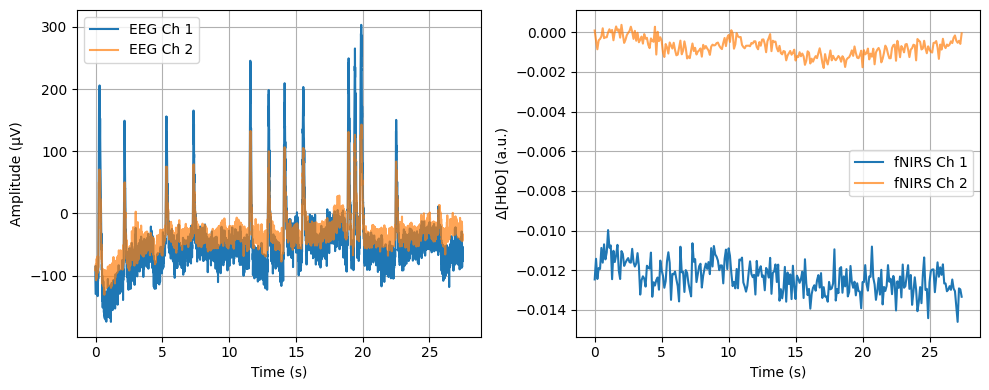

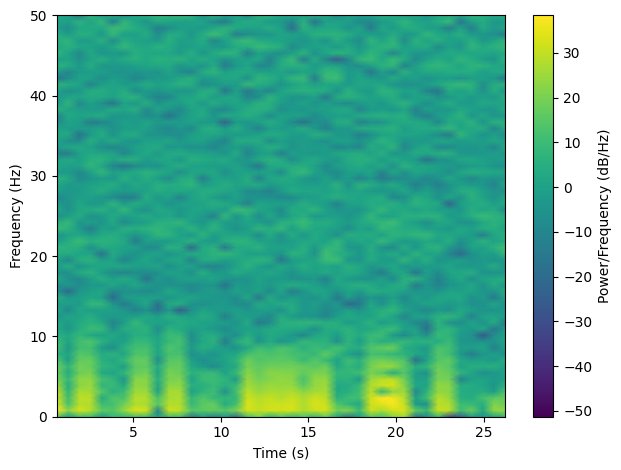

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

# Assume these arrays are loaded
# eeg_data.shape = (590, 5500, 30), nirs_data.shape = (590, 275, 72)

sample_idx = 0
eeg_sample = eeg_data[sample_idx]
nirs_sample = nirs_data[sample_idx]

eeg_fs = 200  # EEG sampling frequency
nirs_fs = 10  # fNIRS sampling frequency

eeg_time = np.arange(eeg_sample.shape[0]) / eeg_fs
nirs_time = np.arange(nirs_sample.shape[0]) / nirs_fs

# --------- Time Series PDF ----------
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(eeg_time, eeg_sample[:, 0], label='EEG Ch 1')
plt.plot(eeg_time, eeg_sample[:, 1], label='EEG Ch 2', alpha=0.7)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(nirs_time, nirs_sample[:, 0], label='fNIRS Ch 1')
plt.plot(nirs_time, nirs_sample[:, 1], label='fNIRS Ch 2', alpha=0.7)
plt.xlabel("Time (s)")
plt.ylabel("Δ[HbO] (a.u.)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("time_series_eeg_nirs.pdf")
plt.show()

# --------- EEG Spectrogram PDF ----------
ch_idx = 0
f, t, Sxx = spectrogram(eeg_sample[:, ch_idx], fs=eeg_fs, nperseg=256, noverlap=128)

plt.figure()
plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
plt.colorbar(label='Power/Frequency (dB/Hz)')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.ylim(0, 50)
plt.tight_layout()
plt.savefig("eeg_spectrogram.pdf")
plt.show()


In [ ]:
eeg_data = np.concatenate(eeg_data, axis=0)
nirs_data = np.concatenate(nirs_data, axis=0)
labels = np.concatenate(labels, axis=0)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
eeg_data_reshaped = eeg_data.reshape(-1, eeg_data.shape[2])

# Apply StandardScaler
eeg_data_scaled_reshaped = scaler.fit_transform(eeg_data_reshaped)

# Reshape back to 3D array (samples, channels, time_points)
eeg_data_scaled = eeg_data_scaled_reshaped.reshape(eeg_data.shape)

# Verify the scaling
print(np.max(eeg_data_scaled))
print(np.min(eeg_data_scaled))

22.29636593472678
-14.705421638633013


In [ ]:
np.shape(eeg_data)

(590, 5500, 30)

In [ ]:
from scipy.signal import resample

target_length = eeg_data.shape[1]
resampled_nirs_data = np.zeros((nirs_data.shape[0], target_length, nirs_data.shape[2]))

for i in range(nirs_data.shape[0]):
    for j in range(nirs_data.shape[2]):
        resampled_nirs_data[i, :, j] = resample(nirs_data[i, :, j], target_length)


min_eeg = np.min(eeg_data)
max_eeg = np.max(eeg_data)
min_nirs = np.min(resampled_nirs_data)
max_nirs = np.max(resampled_nirs_data)

In [ ]:
# del nirs_data
scaled_nirs_data = (resampled_nirs_data - min_nirs) / (max_nirs - min_nirs) * (max_eeg - min_eeg) + min_eeg

In [ ]:
del resampled_nirs_data

In [ ]:
data = np.concatenate((eeg_data, scaled_nirs_data), axis=-1)

In [ ]:
del eeg_data
del scaled_nirs_data

In [ ]:
data = eeg_data_scaled

In [ ]:
channels_eeg = 102
channels_nirs = 72
eeg_shape = (5500, channels_eeg)
nirs_shape = (270, channels_nirs)
latent_dim = 100

In [ ]:
def build_generator(latent_dim, channels, data):
    model = Sequential()
    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(np.shape(data)[1] * channels, activation='tanh'))
    model.add(Reshape(np.shape(data)[1:3]))
    return model

# class ScaleLayer(keras.layers.Layer):
#     def __init__(self, min_value, max_value, **kwargs):
#         super(ScaleLayer, self).__init__(**kwargs)
#         self.min_value = min_value
#         self.max_value = max_value

#     def call(self, inputs):
#         return (inputs + 1.0) * 0.5 * (self.max_value - self.min_value) + self.min_value


def build_discriminator(data):
    model = Sequential()
    model.add(Flatten(input_shape=np.shape(data)[1:3]))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

In [ ]:
min_value = np.min(nirs_data)
max_value = np.max(nirs_data)

# Normalize the data between -1 and +1
normalized_data = ((nirs_data - min_value) / (max_value - min_value)) * 2 - 1

In [ ]:
np.min(normalized_data)

np.float64(-1.0)

In [ ]:
np.shape(normalized_data)

(590, 275, 72)

In [ ]:
channels_eeg = 72
latent_dim = 100
data = normalized_data
generator = build_generator(latent_dim, channels_eeg, data)
discriminator = build_discriminator(data)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# from sklearn.preprocessing import LabelEncoder
# label_encoder = LabelEncoder()
# labels = label_encoder.fit_transform(np.array(labels))

In [ ]:
def train_gan(generator, discriminator, gan, X_train, labels, epochs=10000, batch_size=16, save_interval=1000):
    half_batch = batch_size // 2

    for epoch in range(epochs):

        idx = np.random.randint(0, X_train.shape[0], half_batch)
        real_eeg = X_train[idx]
        labels_real = labels[idx]

        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        fake_eeg = generator.predict(noise)

        labels_fake = np.zeros((half_batch, 1))

        d_loss_real = discriminator.train_on_batch(real_eeg, labels_real)
        d_loss_fake = discriminator.train_on_batch(fake_eeg, labels_fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        labels_gan = np.ones((batch_size, 1))

        g_loss = gan.train_on_batch(noise, labels_gan)

        if epoch % save_interval == 0:
            print(f"Epoch {epoch}, D Loss: {d_loss[0]}, G Loss: {g_loss}")

# train_gan(generator, discriminator, gan, eeg_data, labels)

In [ ]:
train_gan(generator, discriminator, gan, data, labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

In [ ]:
generator.save("/content/drive/MyDrive/generator_wg_nirs.h5")
discriminator.save("/content/drive/MyDrive/discriminator_wg_nirs.h5")

In [ ]:
from tensorflow.keras.models import load_model

custom_objects = {'ScaleLayer': ScaleLayer}
generator = load_model("/content/drive/MyDrive/generator_nback.h5", custom_objects=custom_objects)
discriminator = load_model("/content/drive/MyDrive/discriminator_nback.h5", custom_objects=custom_objects)

NameError: name 'ScaleLayer' is not defined

In [ ]:
synthetic_labels = discriminator.predict(data)
pd.DataFrame(synthetic_labels).to_csv('/content/drive/MyDrive/Sythetic_Labels_NBACK.csv', index = False)

In [ ]:
synthetic_labels = discriminator_eeg.predict(eeg_data)
print(synthetic_labels)

In [ ]:
def generate_synthetic_data(generator, discriminator, num_samples, latent_dim):
    noise = np.random.normal(0, 1, (num_samples, latent_dim))
    synthetic_data = generator.predict(noise)

    # Generate corresponding synthetic labels using the trained discriminator
    synthetic_labels = discriminator.predict(synthetic_data)

    return synthetic_data, synthetic_labels

In [ ]:
num_samples = 1000
latent_dim = 100
synthetic_data, synthetic_labels = generate_synthetic_data(generator, discriminator, num_samples, latent_dim)

print(np.max(synthetic_data))
print(np.min(synthetic_data))

In [ ]:
from scipy.signal import stft
fs = 200
f, t, Zxx = stft(synthetic_data[0, :, 2], fs=fs, nperseg=128, noverlap=64)

plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
plt.colorbar(label='Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('STFT Magnitude')
plt.savefig('stft_synthetic.eps', format='eps')
plt.savefig('stft_synthetic.pdf', format='pdf')
plt.show()

In [ ]:
data = synthetic_data[0, :, 0:5]

plt.figure(figsize=(10, 6))  # Adjust figure size as needed
for i in range(5):
    plt.plot(data[:, i], label=f'Channel {i+1}')

plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Data for First 5 Channels')
plt.legend()
plt.grid(True)
plt.savefig('channels_synthetic.eps', format='eps')
plt.savefig('channels_synthetic.pdf', format='pdf')
plt.show()

In [ ]:
from scipy.signal import stft
fs = 200
f, t, Zxx = stft(normalized_data[0, :, 1], fs=fs, nperseg=128, noverlap=64)

plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
plt.colorbar(label='Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('STFT Magnitude')
plt.savefig('stft_wgData.eps', format='eps')
plt.savefig('stft_wgData.pdf', format='pdf')
plt.show()

In [ ]:
data = normalized_data[0, :, 0:5]

plt.figure(figsize=(10, 6))  # Adjust figure size as needed
for i in range(5):
    plt.plot(data[:, i], label=f'Channel {i+1}')

plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Data for First 10 Channels')
plt.legend()
plt.grid(True)
plt.savefig('channels_wgData.eps', format='eps')
plt.savefig('channels_wgData.pdf', format='pdf')
plt.show()

In [ ]:
data = normalized_data[0, :, :]

# Compute the average across the third axis
data_avg = np.mean(data, axis=1)

# Plot the box plot
plt.figure()
plt.boxplot(data_avg)
plt.title('Box Plot of Synthetic Data')
plt.xlabel('Data')
plt.ylabel('Value')
plt.grid(True)
plt.show()

In [ ]:
def compute_statistics(data):
    statistics = {
        'mean': np.mean(data, axis=(0, 1)),
        'std': np.std(data, axis=(0, 1)),
        'min': np.min(data, axis=(0, 1)),
        'max': np.max(data, axis=(0, 1)),
    }
    return statistics

# Compute statistics for synthetic_data
synthetic_statistics = compute_statistics(synthetic_data)

# Compute statistics for normalized_data
normalized_statistics = compute_statistics(normalized_data)

from tabulate import tabulate

# Assuming synthetic_statistics and normalized_statistics are already computed dictionaries

# Convert dictionaries to lists of tuples for tabulate
synthetic_data_table = [("Mean", *synthetic_statistics['mean']),
                        ("Std", *synthetic_statistics['std']),
                        ("Min", *synthetic_statistics['min']),
                        ("Max", *synthetic_statistics['max'])]

normalized_data_table = [("Mean", *normalized_statistics['mean']),
                         ("Std", *normalized_statistics['std']),
                         ("Min", *normalized_statistics['min']),
                         ("Max", *normalized_statistics['max'])]

# Print tables
print("Statistical properties for synthetic_data:")
print(tabulate(synthetic_data_table, headers=["Statistical Measure", *range(synthetic_data.shape[1])]))

print("\nStatistical properties for normalized_data:")
print(tabulate(normalized_data_table, headers=["Statistical Measure", *range(normalized_data.shape[1])]))

In [ ]:
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, Dense

def calculate_fd(real, synth):
    mu_r, mu_s = np.mean(real, axis=0), np.mean(synth, axis=0)
    cov_r = np.cov(real.T)
    cov_s = np.cov(synth.T)
    fd = np.linalg.norm(mu_r - mu_s)**2 + np.trace(cov_r + cov_s - 2*np.sqrt(cov_r @ cov_s))
    return fd

def calculate_mmd(x, y, gamma=1.0):
    xx = rbf_kernel(x, x, gamma=gamma)
    yy = rbf_kernel(y, y, gamma=gamma)
    xy = rbf_kernel(x, y, gamma=gamma)
    return np.mean(xx) + np.mean(yy) - 2 * np.mean(xy)

real_flat = normalized_data.reshape(normalized_data.shape[0], -1)
synthetic_flat = synthetic_data.reshape(synthetic_data.shape[0], -1)

fd_score = calculate_fd(real_flat, synthetic_flat)
mmd_score = calculate_mmd(real_flat, synthetic_flat)

print("Fréchet Distance (FD):", fd_score)
print("Maximum Mean Discrepancy (MMD):", mmd_score)

# Deep classifier with/without synthetic data
def create_classifier(input_shape):
    model = Sequential([
        Conv1D(32, 3, activation='relu', input_shape=input_shape),
        GlobalAveragePooling1D(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(normalized_data, labels, test_size=0.2)
X_syn_train = synthetic_data[:len(X_real_train)]
y_syn_train = synthetic_labels[:len(X_real_train)]

# Train without augmentation
model_noaug = create_classifier(X_real_train.shape[1:])
model_noaug.fit(X_real_train, y_real_train, epochs=5, verbose=0)
y_pred_noaug = model_noaug.predict(X_real_test) > 0.5
print("Accuracy (no augmentation):", accuracy_score(y_real_test, y_pred_noaug))
print("F1 Score:", f1_score(y_real_test, y_pred_noaug))

# Train with synthetic augmentation
X_aug = np.concatenate([X_real_train, X_syn_train])
y_aug = np.concatenate([y_real_train, y_syn_train])
model_aug = create_classifier(X_aug.shape[1:])
model_aug.fit(X_aug, y_aug, epochs=5, verbose=0)
y_pred_aug = model_aug.predict(X_real_test) > 0.5
print("Accuracy (with synthetic):", accuracy_score(y_real_test, y_pred_aug))
print("F1 Score:", f1_score(y_real_test, y_pred_aug))


In [ ]:
import csv

def save_table_as_csv(table, filename):
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(table)

# Save synthetic_data table as CSV
save_table_as_csv(synthetic_data_table, 'synthetic_data_statistics.csv')

# Save normalized_data table as CSV
save_table_as_csv(normalized_data_table, 'normalized_data_statistics.csv')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming synthetic_statistics and normalized_statistics are already computed dictionaries

# Extract statistical measures
measures = ['mean', 'std']
synthetic_data_values = [synthetic_statistics[measure] for measure in measures]
normalized_data_values = [normalized_statistics[measure] for measure in measures]

# Plotting
x = np.arange(len(synthetic_data_values[0]))  # Assuming all measures have the same number of features

fig, axs = plt.subplots(1, 2, figsize=(16, 6))  # Adjust figsize as needed

for i, measure in enumerate(measures):
    axs[i].bar(x - 0.2, synthetic_data_values[i], width=0.4, label='Synthetic Data')
    axs[i].bar(x + 0.2, normalized_data_values[i], width=0.4, label='Original EEG Data')
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(range(len(synthetic_data_values[0])))
    axs[i].set_title(f'{measure.capitalize()}')
    axs[i].legend()

plt.tight_layout()
plt.savefig('stats_properties.eps', format='eps')
plt.savefig('stats_properties.pdf', format='pdf')
plt.show()

In [ ]:
data = eeg_data[0, :, :]

# Compute the average across the third axis
data_avg = np.mean(data, axis=1)

# Plot the box plot
plt.figure()
plt.boxplot(data_avg)
plt.title('Box Plot of Synthetic Data')
plt.xlabel('Data')
plt.ylabel('Value')
plt.grid(True)
plt.show()

In [ ]:
np.shape(synthetic_data)

In [ ]:
print(np.max(eeg_data))
print(np.min(eeg_data))

NameError: name 'eeg_data' is not defined

In [ ]:
synthetic_labels

In [ ]:
synthetic_labels

In [ ]:
synthetic_labels

In [ ]:
num_samples = 1000
synthetic_data, synthetic_labels = generate_synthetic_data(generator_nirs, discriminator_nirs, num_samples, latent_dim)

print(np.max(synthetic_data))
print(np.min(synthetic_data))

In [ ]:
synthetic_labels

In [ ]:
synthetic_labels

In [ ]:
print(np.max(nirs_data))
print(np.min(nirs_data))

In [ ]:
num_samples = 100
noise = np.random.normal(0, 1, (num_samples, latent_dim))
synthetic_data = generator_nirs.predict(noise)
print(np.max(synthetic_data))
print(np.min(synthetic_data))

In [ ]:
synthetic_labels = discriminator.predict(eeg_data)

In [ ]:
synthetic_labels

In [ ]:
labels[0:10]

In [ ]:
synthetic_labels

In [ ]:
print(np.max(eeg_data[5,:]))
print(np.min(eeg_data[5,:]))

In [ ]:
synthetic_labels

NameError: name 'synthetic_labels' is not defined

In [ ]:
synthetic_data, synthetic_labels = generate_synthetic_data(generator, discriminator, 10000, 100)

In [ ]:
unique_values, counts = np.unique(synthetic_labels, return_counts=True)

# Create a dictionary to store the counts for each unique value
counts_dict = dict(zip(unique_values, counts))

# Print the counts
for value, count in counts_dict.items():
    print(f"Value: {value}, Count: {count}")